In [1]:
import pandas as pd
import json
import numpy as np
import sys
#replace this with the path on your system
sys.path.append('/n/projects/jru/public/IPython_Notebooks/pdbtools/')
import jpdbtools2 as jpt
import os
import glob
import matplotlib.pyplot as plt

In [2]:
#this is the list of queries for our screen (yours will be different)
pipeplist=['target_0_0','target_0_1','target_0_2','target_0_3']
len(pipeplist)

4

In [3]:
def getPAEInteraction(paemat,len1,len2):
    '''
    get's the predicted aligned error for the interaction and each protein
    '''
    paei=0.5*(paemat[:len1,len1:].mean()+paemat[len1:,:len1].mean())
    pae1=paemat[:len1,:len1].mean()
    pae2=paemat[len1:,len1:].mean()
    return paei,pae1,pae2

def analyzeFolder(foldername,currdf=None):
    '''
    this function analyzes a folder and outputs a table of alphafold stats
    foldername contains the predictions and currdf holds predictions that were already made (just copied)
    '''
    #start by getting all of the predictions in out output folder
    predictions=sorted(glob.glob(foldername+'/*_unrelaxed_*.pdb'))
    print(len(predictions),' predictions')
    #get the prediction basenames
    names=[predictions[i].split('/')[-1].split('_unrelaxed')[0] for i in range(len(predictions))]
    predstats=[]
    #now loop through all of the names and get lengths and pae_interaction stats
    for i in range(len(predictions)):
        if(i%500==0):
            print(names[i],i)
        crow1=[]
        #if we've already done some predictions just add them to the list
        if(currdf is not None):
            crow1=currdf[currdf['name']==names[i]]
        if(len(crow1)>0):
            predstats.append(crow1.iloc[0].to_dict())
            continue
        tpdbdf=jpt.cleanpdbdf(jpt.getpdbdf(predictions[i]))
        tlastres=tpdbdf.iloc[-1]['residue']
        pepname=names[i].split('_')[0]
        scorename=foldername+'/'+names[i]+'_scores_rank_001_alphafold2_multimer_v3_model_1_seed_000.json'
        with open(scorename) as f:
            temp=json.load(f)
            tpae=temp['pae']
            ptm=temp['ptm']
            iptm=temp['iptm']
            plddt=np.array(temp['plddt'])
        totlen=len(tpae)
        predstat={}
        predstat['name']=names[i]
        predstat['len1']=totlen-tlastres
        predstat['len2']=tlastres
        tpaeint,tpae1,tpae2=getPAEInteraction(np.array(tpae),predstat['len1'],predstat['len2'])
        predstat['pae_interaction']=tpaeint
        predstat['pae1']=tpae1
        predstat['pae2']=tpae2
        predstat['ptm']=ptm
        predstat['iptm']=iptm
        predstat['plddt1']=plddt[:predstat['len1']].mean()
        predstat['plddt2']=plddt[predstat['len1']:].mean()
        predstats.append(predstat)
    paeintdf=pd.DataFrame(predstats)
    paeintdf=paeintdf.sort_values('pae_interaction')
    return paeintdf

In [4]:
paeintdfs=[]
for i in range(len(pipeplist)):
    paeintdf1=analyzeFolder('outputdir_multimer_msas/'+pipeplist[i])
    paeintdfs.append(paeintdf1)
paeintdf=pd.concat(paeintdfs)
paeintdf=paeintdf.sort_values('pae_interaction').reset_index(drop=True)
paeintdf.to_csv('interactome_predictions.csv')

500  predictions
target_0_design_ppi_0_0_1 0
500  predictions
target_0_design_ppi_0_1_2 0
500  predictions
target_0_design_ppi_100_0_7 0
348  predictions
target_0_design_ppi_110_1_30 0


In [5]:
paeintdf.head(20)

,name,len1,len2,pae_interaction,pae1,pae2,ptm,iptm,plddt1,plddt2
0,target_0_design_ppi_718_1_1378,290,70,3.102797,2.400512,1.959886,0.96,0.94,97.793517,97.473857
1,target_0_design_ppi_837_1_1642,290,86,3.186436,2.354349,2.196299,0.96,0.93,97.955310,97.928605
2,target_0_design_ppi_378_0_621,290,80,3.345590,2.386315,2.260088,0.95,0.93,97.745655,96.773000
3,target_0_design_ppi_179_0_179,290,82,3.389878,2.417979,2.278507,0.95,0.93,97.687207,96.787561
4,target_0_design_ppi_688_1_1310,290,88,3.402754,2.378267,2.340054,0.95,0.93,97.863724,97.377045
5,target_0_design_ppi_264_0_369,290,88,3.410801,2.382359,2.404412,0.95,0.92,97.837724,97.288864
6,target_0_design_ppi_199_0_223,290,75,3.418927,2.375603,2.337266,0.95,0.93,97.930552,97.247467
7,target_0_design_ppi_410_0_695,290,77,3.424646,2.365088,2.239787,0.95,0.94,97.877172,96.990260
8,target_0_design_ppi_46_0_803,290,91,3.447311,2.385073,2.203562,0.95,0.92,97.823517,97.791319
9,target_0_design_ppi_173_0_167,290,74,3.453826,2.434628,2.250351,0.95,0.93,97.651690,96.743649


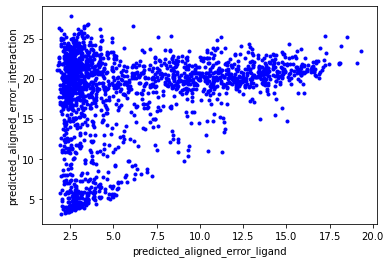

In [6]:
plt.plot(paeintdf['pae2'],paeintdf['pae_interaction'],'b.')
plt.xlabel('predicted_aligned_error_ligand')
plt.ylabel('predicted_aligned_error_interaction')
plt.show()

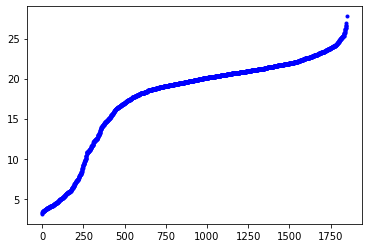

In [7]:
plt.plot(paeintdf['pae_interaction'].values,'b.')

Text(0, 0.5, 'ipTM')

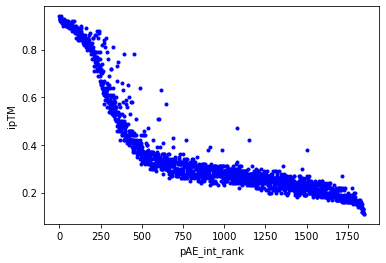

In [8]:
plt.plot(paeintdf['iptm'].values,'b.')
plt.xlabel('pAE_int_rank')
plt.ylabel('ipTM')

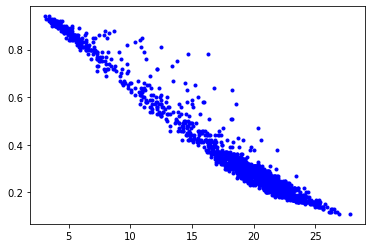

In [9]:
plt.plot(paeintdf['pae_interaction'].values,paeintdf['iptm'].values,'b.')

In [10]:
#now copy anything with a iptm>0.75 or paeint<10 to a special folder up to maxhits
maxhits=500
selintdf=pd.DataFrame(columns=paeintdf.columns)
os.makedirs('selected_predictions',exist_ok=True)
for i in range(maxhits):
    name=paeintdf.iloc[i]['name']
    if((paeintdf.iloc[i]['pae_interaction']<=10.0) | (paeintdf.iloc[i]['iptm']>=0.75)):
        print(name)
        for j in range(len(pipeplist)):
            if(len(glob.glob('outputdir_multimer_msas/'+pipeplist[j]+'/'+name+'*.pdb'))>0):
                os.system('cp outputdir_multimer_msas/'+pipeplist[j]+'/'+name+'* selected_predictions/')
                selintdf.loc[i]=paeintdf.iloc[i]

target_0_design_ppi_718_1_1378
target_0_design_ppi_837_1_1642
target_0_design_ppi_378_0_621
target_0_design_ppi_179_0_179
target_0_design_ppi_688_1_1310
target_0_design_ppi_264_0_369
target_0_design_ppi_199_0_223
target_0_design_ppi_410_0_695
target_0_design_ppi_46_0_803
target_0_design_ppi_173_0_167
target_0_design_ppi_264_1_370
target_0_design_ppi_837_0_1641
target_0_design_ppi_173_1_168
target_0_design_ppi_887_1_1752
target_0_design_ppi_827_1_1620
target_0_design_ppi_771_1_1496
target_0_design_ppi_550_1_1006
target_0_design_ppi_519_0_935
target_0_design_ppi_129_1_70
target_0_design_ppi_75_1_1448
target_0_design_ppi_887_0_1751
target_0_design_ppi_46_1_804
target_0_design_ppi_519_1_936
target_0_design_ppi_688_0_1309
target_0_design_ppi_2_1_226
target_0_design_ppi_128_0_67
target_0_design_ppi_99_1_1848
target_0_design_ppi_680_1_1294
target_0_design_ppi_259_0_357
target_0_design_ppi_771_0_1495
target_0_design_ppi_477_0_841
target_0_design_ppi_841_1_1652
target_0_design_ppi_827_0_1619
ta

In [11]:
selintdf.to_csv('selected_interactions.csv')

In [15]:
#optionally find the sequences corresponding to those hits and output them to a csv
seqdf=pd.DataFrame(columns=list(selintdf.columns)+['sequenceA','sequenceB'])
for i in range(len(selintdf)):
    name=selintdf.iloc[i]['name']
    pdbname=glob.glob('selected_predictions/'+name+'*.pdb')
    tpdbdf=jpt.getCA(jpt.cleanpdbdf(jpt.getpdbdf(pdbname[0])))
    seqa=jpt.getSeq(tpdbdf[tpdbdf['chain']=='A'])[0]
    seqb=jpt.getSeq(tpdbdf[tpdbdf['chain']=='B'])[0]
    seqdf.loc[i]=list(selintdf.iloc[i])+[seqa,seqb]
seqdf.to_csv('selected_interactions_sequences.csv')